## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from scipy import stats
from scipy.stats import entropy, anderson

## Loading in Datasets

In [2]:
ARIMA_forecast = pd.read_csv('datasets/ARIMA/ARIMA_forecast.csv', index_col=0, parse_dates=['date'])
AR_forecast = pd.read_csv('datasets/AR/AR_forecast.csv', index_col=0, parse_dates=['date'])
GARCH_forecast = None
ARCH_forecast = None

In [3]:
def panelDFtoDict(panelDF):
    all_ticks = panelDF['tick'].unique()
    tDFdict = dict()
    for tick in all_ticks:
        tDF = panelDF[panelDF['tick'] == tick]
        tDFdict[tick] = tDF.set_index('date')
    return tDFdict

ARIMA_tDF = panelDFtoDict(ARIMA_forecast)
AR_tDF = panelDFtoDict(AR_forecast)

## Defining a Loss Function

The loss function used here is the **Mean Squared Error (MSE)**, calculated as:

$$\text{Loss} = \frac{1}{2}(\hat{y} - y)^2$$

Where:
$\\    \hat{y} \text{ is the predicted value (forecasted value).}\\$
$y     \text{ is the actual observed value.}$

In [5]:
def loss_function(yhat, y):
    return  np.sum((y - yhat) ** 2)/len(yhat)

In [6]:
print(f'The average loss is: {np.mean(loss_function(preds, actual)):.3f}')
print(f'The total loss is:   {np.sum(loss_function(preds, actual)):.3f}')

NameError: name 'preds' is not defined

In [ ]:
def percentage_loss(yhat, y):
    return np.abs(yhat - y) / y * 100

In [ ]:
print(f'Average loss of: {np.mean(percentage_loss(preds, actual)):.2f}%')

In [ ]:
def log_likelihood(yhat, y):
    residuals = y - yhat
    sigma_squared = np.var(residuals)
    n = len(actual)
    log_likelihood_value = (-n / 2) * np.log(2 * np.pi * sigma_squared) - (1 / (2 * sigma_squared)) * np.sum(residuals ** 2)

    return log_likelihood_value

## Goodness of Fit

In [ ]:
def r_score(yhat, y):
    return r2_score(yhat, y)

print(f'The goodness of fit with an R^2 score of: {r_score(preds, actual):.3f}.\nThis indicates an accuracy of: {r_score(preds, actual) * 100:.2f}%')

## Plotting

In [ ]:
def plot_actual_prediction_residuals(actual, preds):
    residuals = actual - preds

    plt.figure(figsize=(15, 8))
    plt.plot(actual.index, actual, color='b', label='Actual Data', marker='o')
    plt.plot(preds.index, preds, color='r', label='Predicted Data', linestyle='dashed', marker='x')
    plt.title('Actual vs Predicted')
    plt.xlabel('Year')
    plt.ylabel('CDS Spread')
    plt.legend()
    plt.show()

    plt.figure(figsize=(15, 8))
    plt.plot(actual.index, residuals, color='g', label='Residuals', marker='x')
    plt.axhline(0, color='black', linestyle='dashed')
    plt.title('Residuals')
    plt.xlabel('Year')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show()

In [ ]:
plot_actual_prediction_residuals(actual, preds)

## Kolmogorov-Smirnov Test

In [ ]:
def perform_ks_test_actual_vs_preds(actual, preds):
    ks_stat, p_value = stats.ks_2samp(actual, preds)

    print(f"KS Statistic: {ks_stat:.3f}")
    print(f"P-value: {p_value:.3f}")

    if p_value > 0.05:
        print("The actual and predicted data likely come from the same distribution (fail to reject H0).")
    else:
        print("The actual and predicted data do not come from the same distribution (reject H0).")

perform_ks_test_actual_vs_preds(actual, preds)

## Anderson-Darling Test

In [ ]:
print(anderson(actual-preds))

## Kullback–Leibler (KL) divergence

In [ ]:
kl_divergence = entropy(actual, preds)
print(kl_divergence)

## Coverage Probability

In [7]:
def calculate_picp(actual, lower_bounds, upper_bounds):
    within_bounds = np.logical_and(actual >= lower_bounds, actual <= upper_bounds)
    picp = np.mean(within_bounds)
    return picp

In [ ]:
def generate_prediction_intervals(actual, preds):
    margin = np.std(actual - preds) * 1.96  # for 95% CI

    lower_bounds = preds - margin
    upper_bounds = preds + margin

    return lower_bounds, upper_bounds

In [ ]:
lower_bounds, upper_bounds = generate_prediction_intervals(actual, preds)
picp_value = calculate_picp(actual, lower_bounds, upper_bounds)

print(f"Prediction Interval Coverage Probability (PICP) for 95% CI: {picp_value:.4f}.\nThis means {picp_value*100:.2f}% of the data falls within the 95% CI.")

In [ ]:
def plot_actual_prediction_ci(actual, lower_bounds, upper_bounds):
    inside_ci = np.logical_and(actual >= lower_bounds, actual <= upper_bounds)
    plt.figure(figsize=(15, 8))

    plt.scatter(actual.index[~inside_ci], actual[~inside_ci], color='r', label='Actual outside CI')
    plt.fill_between(actual.index, lower_bounds, upper_bounds, color='gray', alpha=0.3, label='95% Prediction Interval')
    plt.xlabel('Year')
    plt.ylabel('CDS Spread')
    plt.title('Actual vs Predicted with 95% Confidence Interval')
    plt.legend()
    plt.show()

In [ ]:
plot_actual_prediction_ci(actual, lower_bounds, upper_bounds)

## Mean Interval Score

In [ ]:
def calculate_mean_interval_score(actual, lower_bounds, upper_bounds, alpha=0.05):
    interval_width = upper_bounds - lower_bounds
    penalty_lower = np.maximum(0, lower_bounds - actual)
    penalty_upper = np.maximum(0, actual - upper_bounds)
    mis_values = interval_width + (2 / alpha) * (penalty_lower + penalty_upper)
    mis = np.mean(mis_values)

    return mis

In [ ]:
mis_value = calculate_mean_interval_score(actual, lower_bounds, upper_bounds)
print(f"Mean Interval Score (MIS): {mis_value:.4f}")

## Calculating Statistics

In [8]:
def RMSE(yhat, y):
    """Calculates the Root Mean Squared Error """
    return  np.sqrt(np.sum((y - yhat) ** 2)/len(yhat))
def MAE(yhat, y, percentage=False):
    """Calculates the Mean Absolute Error """
    if percentage:
        return np.sum(np.abs((y - yhat)/y))/len(yhat) * (100/len(y))
    return  np.sum(np.abs(y - yhat))/len(yhat)
def MPIW(upper_bounds, lower_bounds):
    """Calculates the Mean Prediction Interval Width"""
    return np.sum(upper_bounds - lower_bounds)/len(upper_bounds)
def PIS(actual, lower_bounds, upper_bounds):
    """Calculates the Prediction Interval Sharpness """
    return MPIW(upper_bounds, lower_bounds) * (1 - calculate_picp(actual, lower_bounds, upper_bounds))

In [9]:
RMSE_ARIMA = [RMSE(DF['preds'].values, DF['actual'].values) for DF in ARIMA_tDF.values()]
RMSE_AR = [RMSE(DF['preds'].values, DF['actual'].values) for DF in AR_tDF.values()]
RMSE_GARCH = None
RMSE_ARCH = None

MAE_ARIMA = [MAE(DF['preds'].values, DF['actual'].values) for DF in ARIMA_tDF.values()]
MAE_AR = [MAE(DF['preds'].values, DF['actual'].values) for DF in AR_tDF.values()]
MAE_GARCH = None
MAE_ARCH = None

MAPE_ARIMA = [MAE(DF['preds'].values, DF['actual'].values, percentage=True) for DF in ARIMA_tDF.values()]
MAPE_AR = [MAE(DF['preds'].values, DF['actual'].values, percentage=True) for DF in AR_tDF.values()]
MAPE_GARCH = None
MAE_ARCH = None

CR_ARIMA = [calculate_picp(DF['actual'], DF['lower_95'], DF['upper_95']) for DF in ARIMA_tDF.values()]
CR_AR = [calculate_picp(DF['actual'], DF['lower_95'], DF['upper_95']) for DF in AR_tDF.values()]
CR_GARCH = None
CR_ARCH = None

PIS_ARIMA = [PIS(DF['actual'], DF['lower_95'], DF['upper_95']) for DF in ARIMA_tDF.values()]
PIS_AR = [PIS(DF['actual'], DF['lower_95'], DF['upper_95']) for DF in AR_tDF.values()]
PIS_GARCH = None
PIS_ARCH = None

In [10]:
print(f"Average RMSE for ARIMA: {np.mean(RMSE_AR):.5f}, AR: {np.mean(RMSE_ARIMA):.5f}")
print(f"Average MAE for ARIMA: {np.mean(MAE_ARIMA):.5f}, AR: {np.mean(MAE_ARIMA):.5f}")
print(f"Average CR for ARIMA: {np.mean(CR_ARIMA):.5f}, AR: {np.mean(CR_AR):.5f}")
print(f"Average PIS for ARIMA: {np.mean(PIS_ARIMA):.5f}, AR: {np.mean(PIS_AR):.5f}")

Average RMSE for ARIMA: 5.33009, AR: 5.39330
Average MAE for ARIMA: 2.48767, AR: 2.48767
Average CR for ARIMA: 0.87465, AR: 0.87747
Average PIS for ARIMA: 0.97860, AR: 0.96082


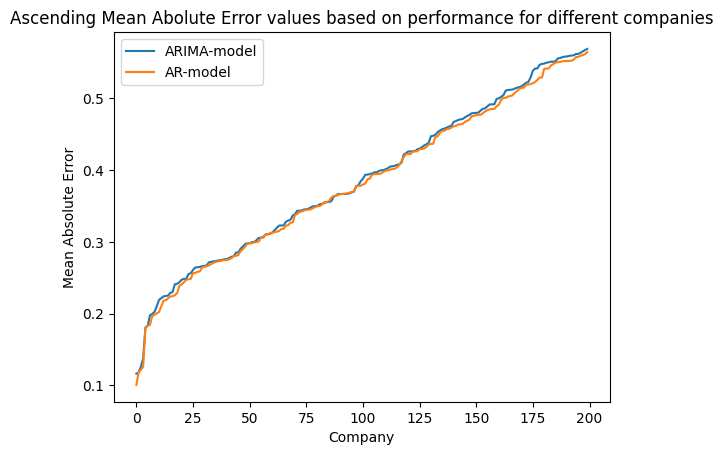

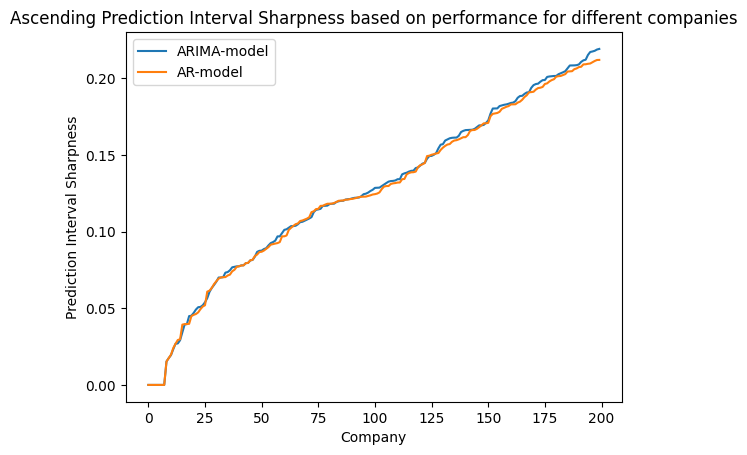

In [51]:
def get_sorted_metrics(ticks, metric_scores):
    tick_metric_dict = {tick: mae for tick, mae in zip(ticks, metric_scores)}
    sorted_dict = dict(sorted(tick_metric_dict.items(), key=lambda x: x[1]))
    return sorted_dict

plt.plot(list(get_sorted_metrics(ARIMA_tDF.keys(), MAE_ARIMA).values())[:200], label="ARIMA-model")
plt.plot(list(get_sorted_metrics(AR_tDF.keys(), MAE_AR).values())[:200], label="AR-model")
plt.xlabel("Company")
plt.ylabel("Mean Absolute Error")
plt.title("Ascending Mean Abolute Error values based on performance for different companies")
plt.legend()
plt.show()

plt.plot(list(get_sorted_metrics(ARIMA_tDF.keys(), PIS_ARIMA).values())[:200], label="ARIMA-model")
plt.plot(list(get_sorted_metrics(AR_tDF.keys(), PIS_AR).values())[:200], label="AR-model")
plt.xlabel("Company")
plt.ylabel("Prediction Interval Sharpness")
plt.title("Ascending Prediction Interval Sharpness based on performance for different companies")
plt.legend();

(array([415.,  66.,  29.,   8.,   3.,   6.,   3.,   0.,   1.,   0.,   2.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   1.,   0.,
          0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   1.]),
 array([ 0.        ,  0.83474133,  1.66948267,  2.504224  ,  3.33896534,
         4.17370667,  5.008448  ,  5.84318934,  6.67793067,  7.51267201,
         8.34741334,  9.18215467, 10.01689601, 10.85163734, 11.68637868,
        12.52112001, 13.35586134, 14.19060268, 15.02534401, 15.86008534,
        16.69482668, 17.52956801, 18.36430935, 19.19905068, 20.03379201,
        20.86853335, 21.70327468, 22.53801602, 23.37275735, 24.20749868,
        25.04224002, 25.87698135, 26.71172269, 27.54646402, 28.38120535,
        29.21594669, 30.05068802, 30.88542936, 31.72017069, 32.55491202,
        33.38965336, 34.22439469, 35.05913603, 35.89387736, 36.72861869,
 

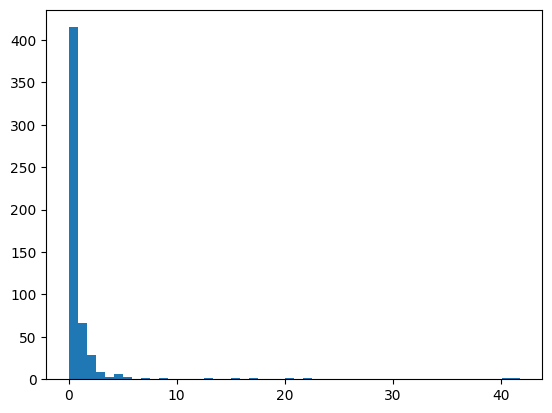

In [61]:
plt.hist(PIS_ARIMA, bins=50)